In [ ]:
# Basic data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classical NLP
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag

# Transformers and deep learning
!pip install -q transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch (for transformers)
import torch
from torch.utils.data import Dataset, DataLoader

# Download NLTK assets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Load the dataset
df = pd.read_csv('/content/spam.csv', encoding='ISO-8859-1')

# Display the first few rows
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Check the column names and data types
print(df.columns)

# Check for null values
print(df.isnull().sum())


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [ ]:
# Keep only the first two columns and rename them
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

# Encode label: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Drop any rows with missing text (just in case)
df.dropna(inplace=True)

# Check the result
print(df.head())

# Class distribution
print("\nClass distribution:")
print(df['label'].value_counts())


   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Class distribution:
label
0    4825
1     747
Name: count, dtype: int64


Classical NLP Preprocessing

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    processed = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(processed)

# Apply the fixed preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)

# Show sample
df[['text', 'processed_text']].head()


,text,processed_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


Training the Classical NLP Model (Logistic Regression)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Vectorize processed text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_text'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9488789237668162

Confusion Matrix:
 [[961   4]
 [ 53  97]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.65      0.77       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



In [ ]:
!pip install -q transformers


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
tokens = tokenizer(
    list(df['text']),  # raw text, not processed_text
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Prepare labels
labels = torch.tensor(df['label'].values)

# Custom Dataset class
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create dataset
dataset = SpamDataset(tokens, labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

# Split inputs and labels
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Use Subset to split
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Re-tokenize using DistilBERT tokenizer
tokens = tokenizer(
    list(df['text']),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)


In [ ]:
# Prepare labels again
labels = torch.tensor(df['label'].values)

# Reuse SpamDataset class
class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create dataset
dataset = SpamDataset(tokens, labels)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Create train/val indices
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

# Create subsets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)


In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=20,
    logging_dir='./logs',
    logging_steps=5
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Step,Training Loss
5,0.378700
10,0.137200
15,0.167700
20,0.019800
25,0.014300
30,0.127100
35,0.004200
40,0.004200
45,0.009600
50,0.095800


TrainOutput(global_step=446, training_loss=0.06597646726076094, metrics={'train_runtime': 2717.5466, 'train_samples_per_second': 1.64, 'train_steps_per_second': 0.164, 'total_flos': 147601798952448.0, 'train_loss': 0.06597646726076094, 'epoch': 1.0})

In [ ]:
# Run evaluation
eval_results = trainer.evaluate()

# Show evaluation metrics
print("Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation results:
eval_loss: 0.02776859700679779
eval_accuracy: 0.9937219730941704
eval_f1: 0.9764309764309764
eval_precision: 0.9863945578231292
eval_recall: 0.9666666666666667
eval_runtime: 208.3554
eval_samples_per_second: 5.351
eval_steps_per_second: 0.269
epoch: 1.0


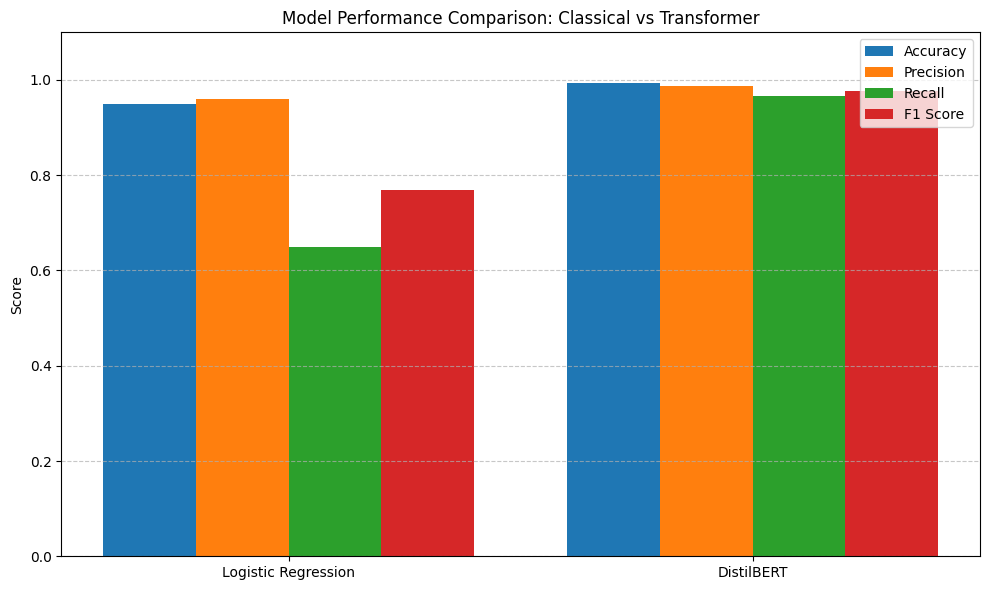

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'DistilBERT']

# Performance metrics from both models
accuracy = [0.9489, 0.9937]
precision = [0.96, 0.9864]
recall = [0.65, 0.9667]
f1 = [0.77, 0.9764]

# Set bar width and positions
bar_width = 0.2
x = np.arange(len(models))

# Plot each metric
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5 * bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x - 0.5 * bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 0.5 * bar_width, recall, width=bar_width, label='Recall')
plt.bar(x + 1.5 * bar_width, f1, width=bar_width, label='F1 Score')

# Labeling and layout
plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Model Performance Comparison: Classical vs Transformer")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


Getting Misclassified Examples (False Positives / Negatives)

In [ ]:
# Make predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Find false positives and false negatives
false_positives = np.where((preds == 1) & (true_labels == 0))[0]
false_negatives = np.where((preds == 0) & (true_labels == 1))[0]

# Print a few false positives
print("\nFalse Positives (Ham misclassified as Spam):")
for idx in false_positives[:3]:
    print(df.iloc[val_idx[idx]]['text'])

# Print a few false negatives
print("\nFalse Negatives (Spam misclassified as Ham):")
for idx in false_negatives[:3]:
    print(df.iloc[val_idx[idx]]['text'])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



False Positives (Ham misclassified as Spam):
Total video converter free download type this in google search:)
645

False Negatives (Spam misclassified as Ham):
You have an important customer service announcement from PREMIER.
Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?
thesmszone.com lets you send free anonymous and masked messages..im sending this message from there..do you see the potential for abuse???


In [ ]:
!pip install numpy==1.24.4 --force-reinstall


  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
from nltk.tokenize import TreebankWordTokenizer

# Use Treebank tokenizer instead of word_tokenize()
tokenizer = TreebankWordTokenizer()

# Updated cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    return tokens

# Recreate corpus
corpus = df['text'].apply(clean_text).tolist()
print("Sample:", corpus[0])


Sample: ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']


In [ ]:
from gensim.models import Word2Vec

# Train CBOW model (sg=0)
cbow_model = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,  # CBOW
    epochs=20
)

# Train Skip-gram model (sg=1)
skipgram_model = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # Skip-gram
    epochs=20
)

print("CBOW and Skip-gram models trained successfully.")


CBOW and Skip-gram models trained successfully.


In [ ]:
# Words to test (must exist in your corpus)
target_words = ['free', 'win', 'call', 'urgent']

# Check most similar words using CBOW
print(" CBOW model - Most similar words:")
for word in target_words:
    if word in cbow_model.wv:
        print(f"\n{word} →", cbow_model.wv.most_similar(word, topn=5))
    else:
        print(f"\n'{word}' not in vocabulary.")

# Check most similar words using Skip-gram
print("\nSkip-gram model - Most similar words:")
for word in target_words:
    if word in skipgram_model.wv:
        print(f"\n{word} →", skipgram_model.wv.most_similar(word, topn=5))
    else:
        print(f"\n'{word}' not in vocabulary.")


 CBOW model - Most similar words:

free → [('picsfree', 0.9077228307723999), ('nokia', 0.892386794090271), ('video', 0.889717698097229), ('colour', 0.8752741813659668), ('tonesu', 0.8715208172798157)]

win → [('chance', 0.9451740980148315), ('comp', 0.8933207988739014), ('weekly', 0.893290638923645), ('wkly', 0.8919091820716858), ('wkentp', 0.885402500629425)]

call → [('quoting', 0.8199047446250916), ('arrive', 0.8171467781066895), ('landline', 0.7903481125831604), ('dateboxessexcmxn', 0.7850258946418762), ('code', 0.7850165963172913)]

urgent → [('xxxxxxxxx', 0.922655463218689), ('shows', 0.9217786192893982), ('important', 0.9193018674850464), ('added', 0.9112470149993896), ('ending', 0.9083660244941711)]

Skip-gram model - Most similar words:

free → [('pptxt', 0.638691246509552), ('unlimited', 0.630217432975769), ('increments', 0.6282681822776794), ('phones', 0.6269180178642273), ('mtalk', 0.6164711713790894)]

win → [('wkly', 0.784694492816925), ('comp', 0.7824850678443909), ('cha

In [ ]:
# Analogy: win - prize + cash ≈ ?
try:
    result = cbow_model.wv.most_similar(positive=['win', 'cash'], negative=['prize'])
    print("\n CBOW Analogy Test: win - prize + cash =", result[0])
except:
    print("\nAnalogy words not in vocabulary.")



 CBOW Analogy Test: win - prize + cash = ('chance', 0.8927972912788391)


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

# Re-initialize tools
tokenizer = TreebankWordTokenizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)

# Check
df[['text', 'processed_text']].head()


,text,processed_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though



Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.65      0.77       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115

ROC-AUC Score: 0.9866666666666666


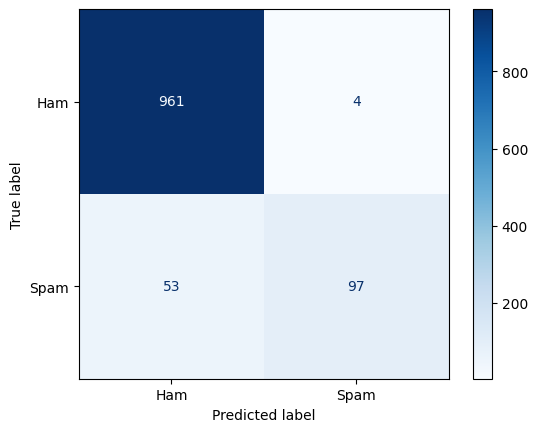

In [ ]:
# 1. TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['processed_text']  # From Task 2
y = df['label']

vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# 2. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# 3. Train baseline classifier
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Predict and evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap='Blues')
